## CST 495 Project 1
Authors: Laura, Brandon

## Introduction
Our goal for this project was to take the Porto Seguro's Safe Driver Prediction dataset and predict if a given person would file an insurance claim within the next year.  To do so, we performed several different transformations to the dataset, largely removing and replacing missing data and scaling as appropiate.  We then leveraged different machine learning methods on the data before concluding that a GradientBoostingClassifier worked well.  

Because this is a competition, we are not given the full dataset. This is because if competitors had access to the test data, people would be able to take advantage and possible get higher scores than they should. The provided test test set is what is being imported and is what we are training our data with.

Before we even started to load and analyze the dataset, there was a lot of information about the features presented. There are three types of features, binary, categorical and normal numeric numbers. There is a lot of missing data in the features as well, sometimes representing a huge part of the features.

## Data Preparation and Exploration
We start our data exploration by finding out how many NaNs there are in our dataset.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
dat = pd.read_csv("data/train.csv")
X_orig = dat.loc[:, dat.columns != "target"]
y_orig = dat.loc[:, "target"]
#count_nan = len(dat) - dat.count()
#print(f"Number of NaNs: {count_nan}")

There are a significant number of NaNs in several of the features. If we chose to ignore them, or assume that there is reason for these numbers to be missing, we might miss something. Instead, we process the data in a realistic and logical way.

In [3]:
X_no_neg = X_orig
y_no_neg = y_orig
cat = pd.DataFrame()
bn = pd.DataFrame()
norm = pd.DataFrame()
ids = X_orig['id']

## We ignore the id column for this step
for i in X_orig.columns[1:]:
    if "cat" in i:
        # Transform Median
        cat[i] = dat.loc[:, i]
    elif "bin" in i:
        # Transform
        bn[i] = dat.loc[:, i]
    else:
        # Do something
        norm[i] = dat.loc[:, i]
 

<h4>Categorical Features</h4> Amount of missing data in each categorical feature

In [4]:
print((cat == -1).sum())
cat_nan_count = (cat == -1).sum().sum()    
print(f"Number of -1 in data: {cat_nan_count}")

ps_ind_02_cat       216
ps_ind_04_cat        83
ps_ind_05_cat      5809
ps_car_01_cat       107
ps_car_02_cat         5
ps_car_03_cat    411231
ps_car_04_cat         0
ps_car_05_cat    266551
ps_car_06_cat         0
ps_car_07_cat     11489
ps_car_08_cat         0
ps_car_09_cat       569
ps_car_10_cat         0
ps_car_11_cat         0
dtype: int64
Number of -1 in data: 696060


<h4>Binary Features</h4>
Amount of missing data in each column of the binary features (None)

In [5]:
print((bn == -1).sum())
print("There are no negatives in binary data set")

ps_ind_06_bin     0
ps_ind_07_bin     0
ps_ind_08_bin     0
ps_ind_09_bin     0
ps_ind_10_bin     0
ps_ind_11_bin     0
ps_ind_12_bin     0
ps_ind_13_bin     0
ps_ind_16_bin     0
ps_ind_17_bin     0
ps_ind_18_bin     0
ps_calc_15_bin    0
ps_calc_16_bin    0
ps_calc_17_bin    0
ps_calc_18_bin    0
ps_calc_19_bin    0
ps_calc_20_bin    0
dtype: int64
There are no negatives in binary data set


<h4>Normal/Numerical Features</h4> Amount of missing data in each column of the numerical features

In [6]:
print((norm==-1).sum())
mx = (norm==-1).sum().max()

print(f"One feature, 'ps_reg_03', has about {mx/float(len(norm)) * 100}% of the data is missing, so we are going to assume that there is some significance to the lack of data.")

ps_ind_01          0
ps_ind_03          0
ps_ind_14          0
ps_ind_15          0
ps_reg_01          0
ps_reg_02          0
ps_reg_03     107772
ps_car_11          5
ps_car_12          1
ps_car_13          0
ps_car_14      42620
ps_car_15          0
ps_calc_01         0
ps_calc_02         0
ps_calc_03         0
ps_calc_04         0
ps_calc_05         0
ps_calc_06         0
ps_calc_07         0
ps_calc_08         0
ps_calc_09         0
ps_calc_10         0
ps_calc_11         0
ps_calc_12         0
ps_calc_13         0
ps_calc_14         0
dtype: int64
One feature, 'ps_reg_03', has about 18.106489788512327% of the data is missing, so we are going to assume that there is some significance to the lack of data.


Though there are few features with NaNs, those that do have NaNs tend to have large amounts.  Without knowledge of what the features actually are, it is difficult to know if the lack of data is truly significant. We decided to use a pipeline to replace the missing values with the mean of the feature. We also scaled the data using a StandardScaler. We decided to use this because there is a huge amount of data, around 500,000 instances. However, only ~3% of the data is in class 1, while 96% is in class 0. Using a z-score can help us vizualize and quickly detect any outliers and if they have anything to do with the instance's class being a 1 or a 0.

In [25]:
temp = []
for feature in cat:
    if feature != "ps_car_03_cat" and feature != "ps_car_05_cat":
        temp.append(pd.get_dummies(cat[feature]))

new_cat = pd.DataFrame()
for feature in temp:
    new_cat = pd.concat([new_cat, feature], axis=1)

In [27]:
pipe = Pipeline([
       ("remove_neg_ones", Imputer(missing_values=-1, strategy="mean")),
        ("z-scaling", StandardScaler())
        ])

scaled_norm = pd.DataFrame(pipe.fit_transform(norm), columns = norm.columns)
X_final = pd.concat([bn, new_cat, scaled_norm], axis=1)
X_orig = X_final

In [9]:
X_feature_test = pd.concat([bn, cat, scaled_norm], axis=1)
clf = GradientBoostingClassifier(n_estimators=50)
clf.fit(scaled_norm, y_orig)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

We used the feature importances of a GradientBoostingClassifer to determine the ten most important features from the non-binary/non-catagorical data.

In [10]:
features = clf.feature_importances_
important_features = scaled_norm[scaled_norm.columns[np.argsort(-features)[:10]]]

from pprint import pprint
pprint(list(scaled_norm.columns[np.argsort(-features)[:10]]))

['ps_car_13',
 'ps_ind_03',
 'ps_ind_15',
 'ps_ind_01',
 'ps_car_14',
 'ps_reg_03',
 'ps_reg_01',
 'ps_reg_02',
 'ps_car_11',
 'ps_car_12']


Unfortunately, the graphs do not reveal much about the dataset.  However, the lack of correlation between the important features is noteworthy.

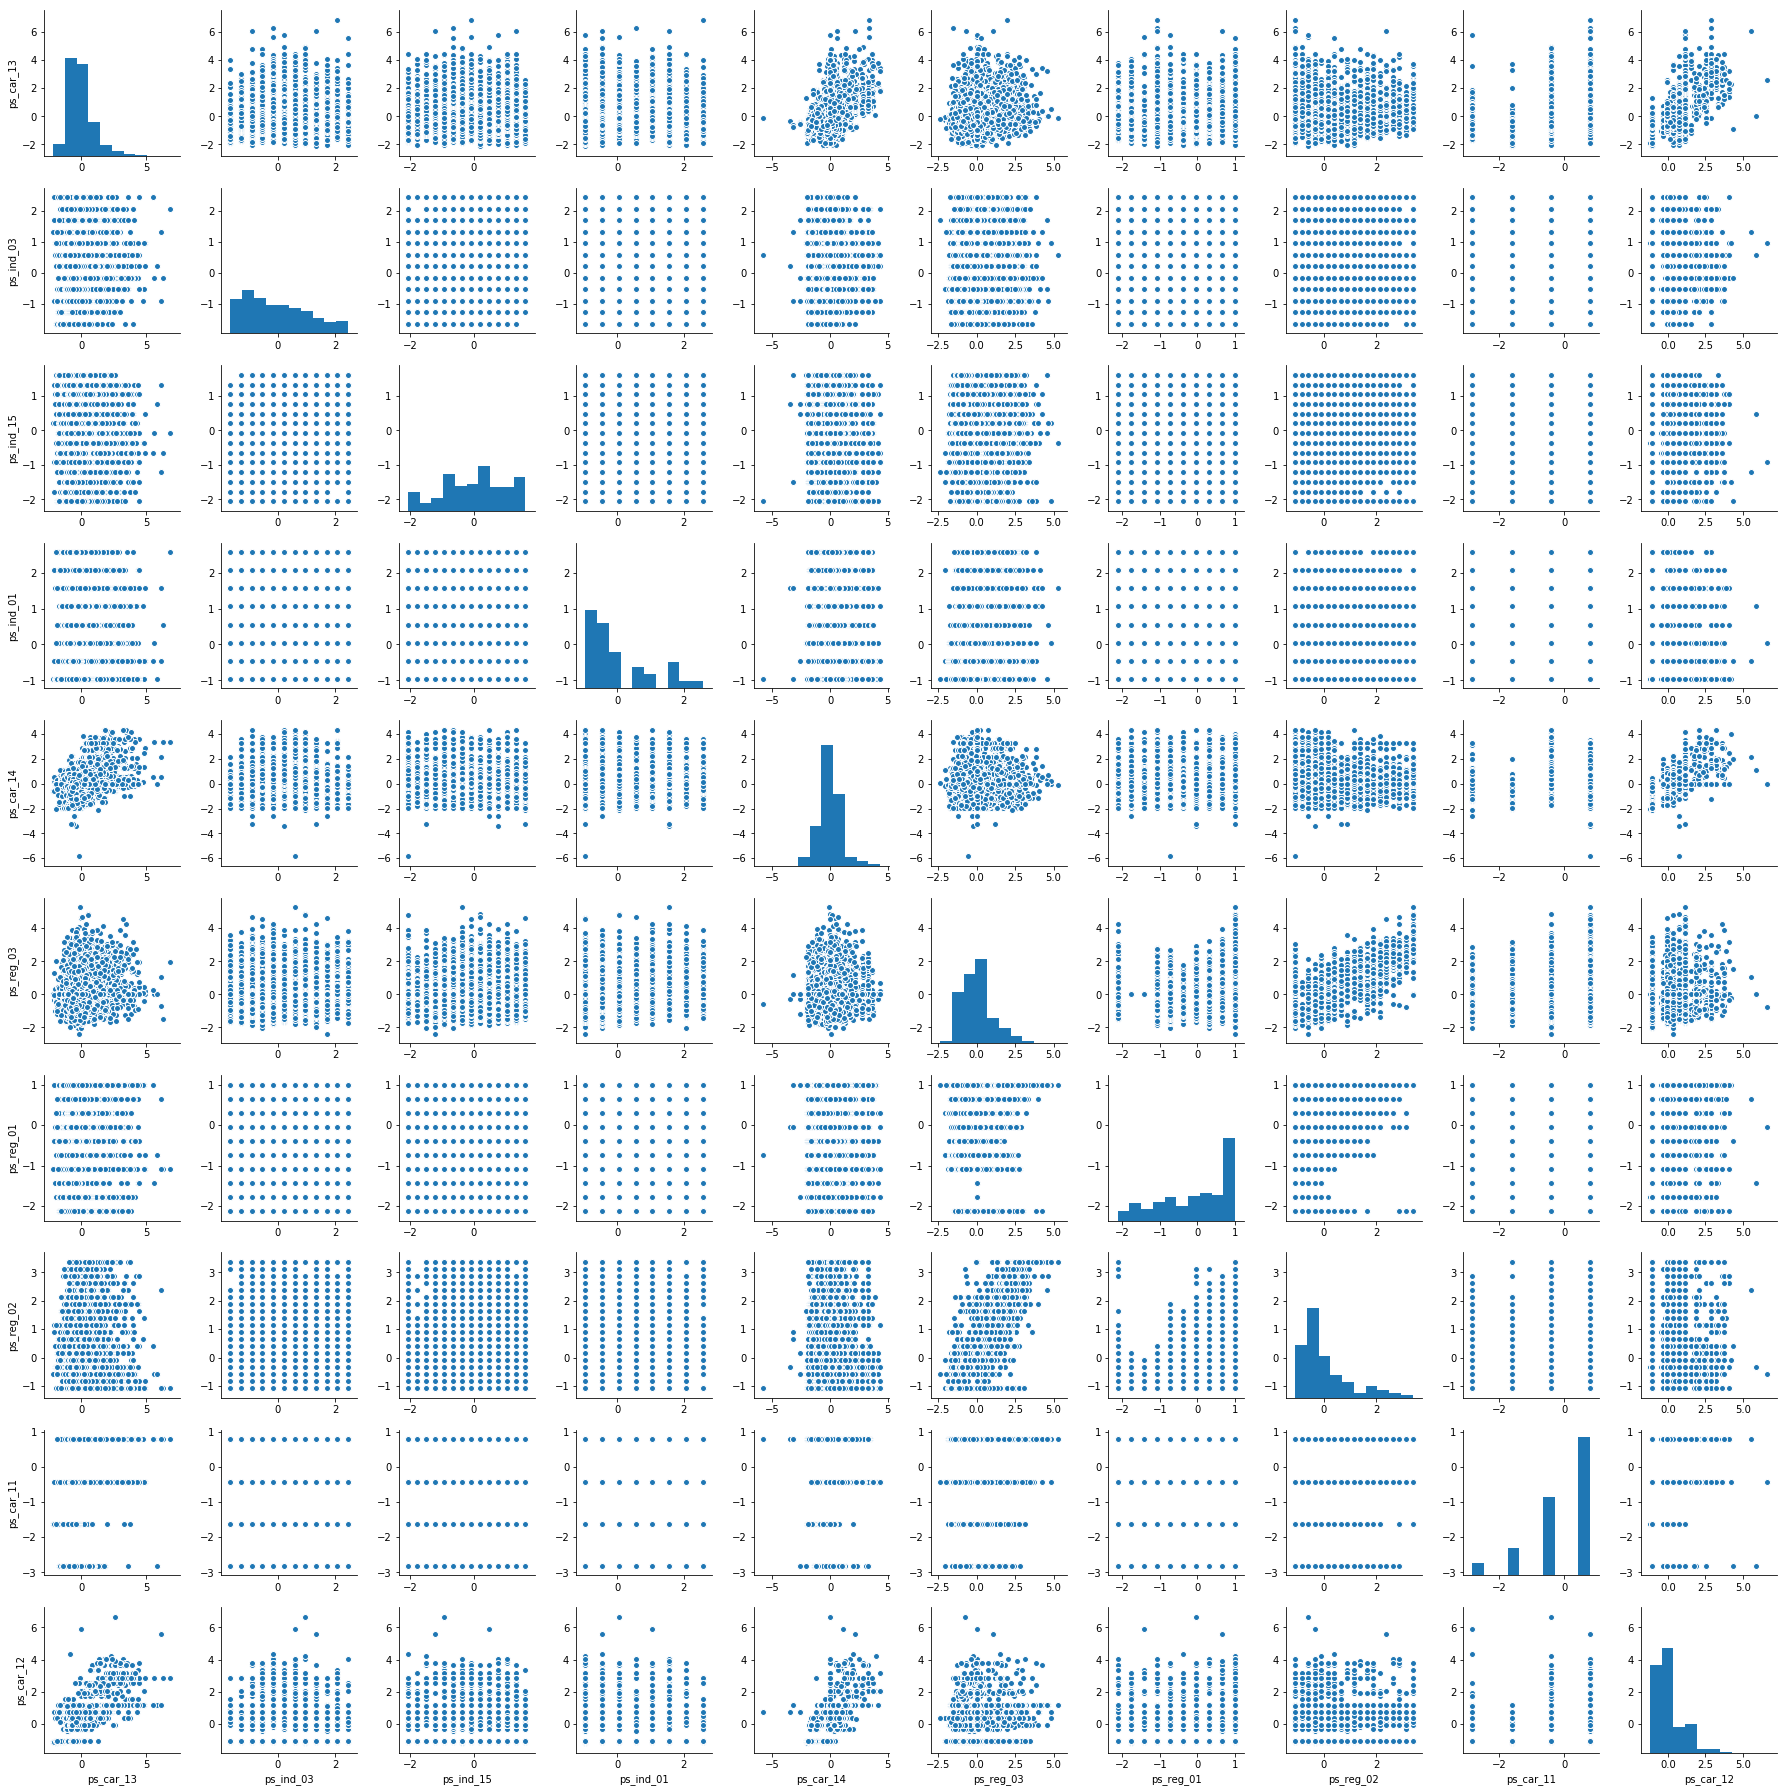

In [11]:
%matplotlib inline
sns.pairplot(important_features.sample(frac=.01))

There does seem to be some sort of correlation between the features 'ps_car_13' and 'ps_car_15'.

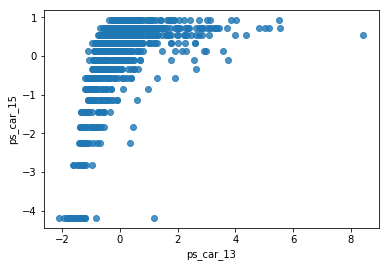

In [12]:
%matplotlib inline
sns.regplot(scaled_norm['ps_car_13'][:1000], scaled_norm['ps_car_15'][:1000], fit_reg=False)

## Training
~96% of the data is class 0, and ~3% is class 1. This means that simply guessing 0 for each instance would yield a 96% accuracy rate. To focus on predicting the positive class, the training set can be changed to a 50/50 solution, where 50% of the data is classified at 0 and the other 50% is class 1. This ensures that the model has enough training instances of class 1 to properly make predictions when the test set contains a 1. To make the training set larger, we sample four times the amount of class 1 instances, and the same amount for the class 0 instances with replacement. This upsampling allows for more data to train on.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig)

In [37]:
X_ones = X_train.loc[y_train==1, :]
X_ones = pd.DataFrame(X_ones)
X_ones = X_ones.sample(n=(len(X_ones)*4), replace=True)
y_ones = y_train[y_train==1]
X_zeroes = X_train.loc[y_train==0, :]
X_zeroes = pd.DataFrame(X_zeroes)

dat_ones = X_ones
dat_ones["target"] = [1] * (len(X_ones))
dat_f = pd.DataFrame(X_zeroes.sample(n=(len(X_ones)), replace=True))
dat_f["target"] = np.zeros(len(dat_f))
dat_ones = dat_ones.append(dat_f.sample(n=(len(dat_ones))))

In [38]:
X_shrunk = dat_ones.loc[:, dat_ones.columns != "target"]
y_shrunk = dat_ones.target

For this Kaggle competition, all scores are based upon the results of these gini functions.  The gini_normalized function computes a number between zero and one that is directly related to the AUC.

In [39]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
     assert( len(actual) == len(pred) )
     all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
     all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
     totalLosses = all[:,0].sum()
     giniSum = all[:,0].cumsum().sum() / totalLosses
 
     giniSum -= (len(actual) + 1) / 2
     return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

There has been enough preprocessing and data exploration to test out how the training set works on a model. After using a default GradientBoostingClassifier, the predictions are evaluated with the gini_normalized function. 

In [40]:
clf = GradientBoostingClassifier()
clf.fit(X_shrunk, y_shrunk)
predicted = clf.predict_proba(X_test)

In [41]:
print(f"Gini score for default GradientBoostingClassifier {gini_normalized(y_test, predicted[:,1])}")

Gini score for default GradientBoostingClassifier 0.2772878035071227


This gini score seems to be rather high. Now, the original, non-50/50 training data is put into a default Gradient Boosting Classifier as a comparission.

In [42]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
predicted = clf.predict_proba(X_test)

In [43]:
print(f"Gini score for default GradientBoostingClassifier {gini_normalized(y_test, predicted[:,1])}")

Gini score for default GradientBoostingClassifier 0.2826686880279662


The 50/50 upsampled dataset did not perform better than the original training set. We believe that this could be the result of training with too many duplicate instances of class 1. In the regular training set, there is a realistic amount of class 1 instances.

## Results
There were many obstacles to overcome in this dataset. The most difficult aspect of this challange was accounting for the target class imbalance.  We chose upsampling to resolve the imbalance.  However, it does not appear to lead to any performance increase over simply using the entire data set.  Many different classifiers and regressors were tested with the upsampled dataset and the full dataset.  Using defaults for each, GradientBoostClassifier was the clear winner.  It is possible, even likely, that other methods could work better than GradientBoosting, given the correct hyperparameters. However, with limited computing power, manhy would require far too much time to compute.

Running our project multiple times to get an average of the gini_normalized score would get a more accurate representation of how well our algorithm performs compared to others. The Gradient Boosting Classifier takes around seven minutes to run each time and the scores tend to vary. With each run of the test_train_split, there is a different score. The score seems to depend on which samples were randomly selected to be trained and tested on the data. There is usually a .004 change in the data, which compared to how our competitors did, was a huge step up and down, ranging from the top 100s of teams to the top 300 teams.

Something that we also noticed is that we would get different accuracies depending on which version of python and which version of scikit-learn we were using. Python 3.6 tends to perform better on the data versus Python 3.5, and Scikit-learn 0.18.0 performed worse than 0.19.0. The combination of Python 3.6 and Scikit-learn 0.19.0 is the combination that we found to be more accurate. Our hypothesis is that this is most likley because of different improvements that were made in the libraries and in the newer version of python, however we have not proven this.